In [110]:
# setup random indicies
import numpy as np

np.random.seed(9)

house_ids = range(1,1461)
random_id = np.random.choice(house_ids, 1460, replace = False)


# load df
import pandas as pd
df = pd.read_csv("../../data/train_model.csv")

# randomized index
df.drop(columns = ['Unnamed: 0', 'Id'], inplace = True)
df['random_id'] = random_id
df.set_index('random_id', inplace = True)
df.sort_index(inplace=True)
df.head(5)

# remove outliers
#df.drop([907, 465], inplace=True)

# log transform SalePrice
#df['SalePrice'] = np.log(df.SalePrice)

df.head(5)

,LotFrontage,LotArea,YearBuilt,GrLivArea,YrSold,SalePrice,MSZoning_RL,MSZoning_RMH,Alley_NoAccess,LotShape_Regular,...,OpenPorchSF_OpenPorch_Yes,Fence_no_fence,MoSold_peak_months,SaleType_non_deed,SaleCondition_not_normal,IsVinyl_yes,FullBaths_<=1FullBath,FullBaths_>=3FullBaths,HalfBaths_>=1HalfBaths,Enclosed_combined_EnclosedPorch_Yes
random_id,,,,,,,,,,,,,,,,,,,,,
1,87.0,9246,37,1656,2008,135000,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
2,60.0,7200,60,1904,2009,138000,1,0,1,1,...,0,0,1,0,0,1,0,0,1,1
3,74.0,8532,56,1297,2009,153000,1,0,1,1,...,0,1,0,0,0,0,1,0,1,0
4,47.0,53504,7,3279,2010,538000,1,0,1,0,...,1,1,1,0,0,0,0,1,1,1
5,82.0,9430,11,2365,2009,337000,1,0,1,1,...,1,1,1,0,0,1,0,1,1,1


In [76]:
test_1 = df.iloc[0:292,:]
test_2 = df.iloc[292:584,:]
test_3 = df.iloc[584:876,:]
test_4 = df.iloc[876:1168,:]
test_5 = df.iloc[1168:1460,:]
print(len(test_1))
print(len(test_2))
print(len(test_3))
print(len(test_4))
print(len(test_5)) # note 2 fewer due to dropped outliers above

292
292
292
292
290


In [84]:
group_test = test_1.copy()
group_train = pd.concat([test_2, test_3, test_4, test_5])
group_train.shape
#group_train.head(5)

(1166, 70)

In [81]:
p_test = test_2.copy()
p_train = pd.concat([test_1, test_3, test_4, test_5])
p_train.shape
#p_train.head(5)

(1166, 70)

In [62]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [111]:
x_df = df.loc[:, df.columns != 'SalePrice']
y_df = df['SalePrice']

In [112]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
x = sm.add_constant(x_df)
y = y_df
model_fit = sm.OLS(y, x).fit()
#print(model_fit.summary())

In [113]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

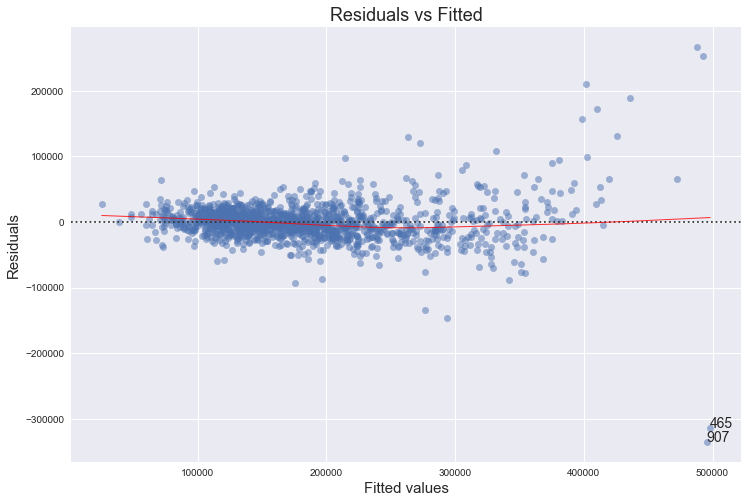

In [114]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'SalePrice',data=df, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

#annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:2]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

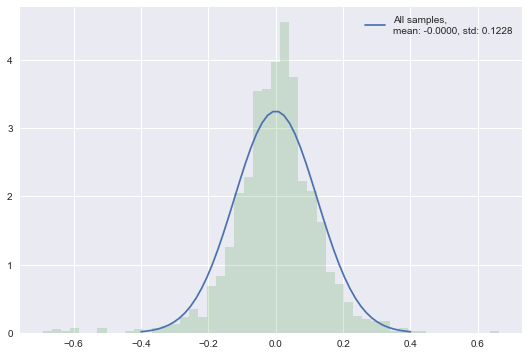

In [97]:
plt.figure(figsize=(9, 6))
#plt.xlim(-0.4, 0.4)
#plt.ylim(0, 4.3)
plt.hist(model_residuals, color='green', bins=50, normed=True, alpha=0.15)
my_norm = stats.norm(np.mean(model_residuals), np.std(model_residuals)).pdf
label = 'All samples,\nmean: %.4f, std: %.4f' % (np.mean(model_residuals), np.std(model_residuals))
plt.plot(np.linspace(-0.4, 0.4), my_norm(np.linspace(-0.4, 0.4)), label=label)
plt.legend()
plt.show()

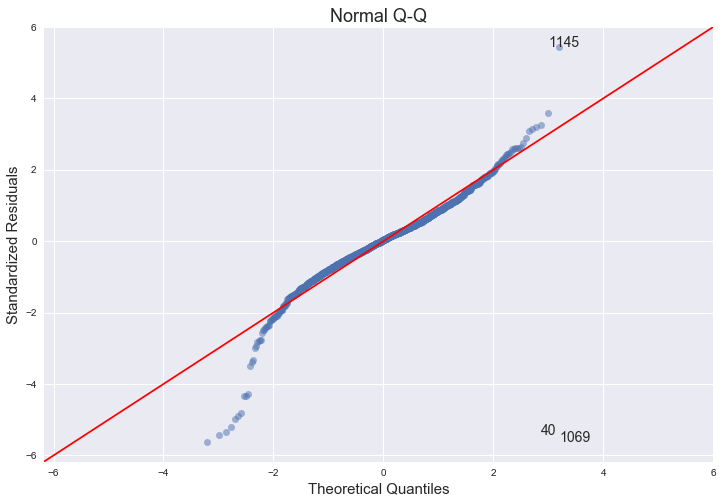

In [99]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

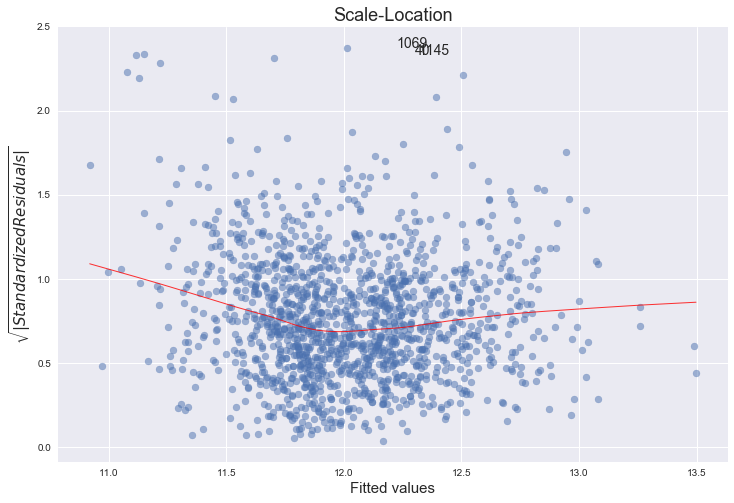

In [100]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

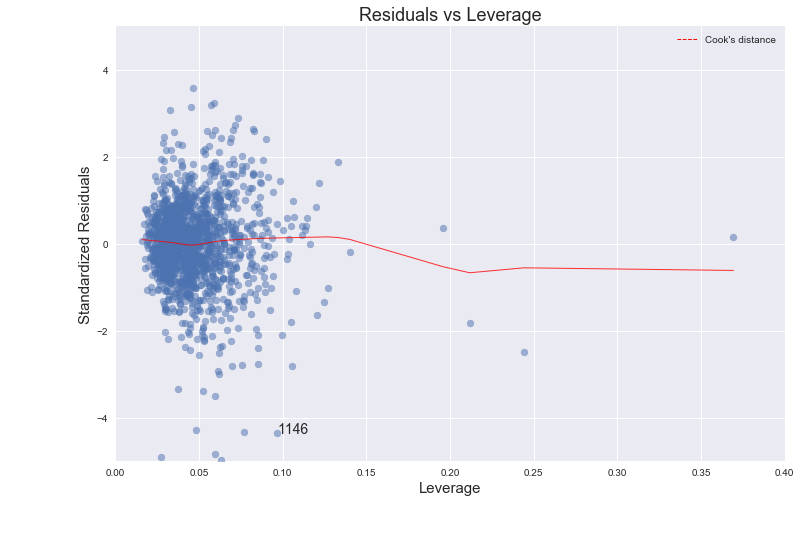

In [101]:

plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.4)
plot_lm_4.axes[0].set_ylim(-5, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');

## Model

In [68]:
x_train = p_train.loc[:, p_train.columns != 'SalePrice']  # input varialbe
y_train = p_train['SalePrice']  # output variable

x_test = p_test.loc[:, p_test.columns != 'SalePrice']
y_test = p_test['SalePrice']

In [70]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
model_sk = ols.fit(x_train, y_train)
print("Intercept: %f" %ols.intercept_)
print("Coefficients: %s" %str(ols.coef_))
print("R^2: %f" %(ols.score(x_train, y_train)))
print("R^2: %f" %(ols.score(x_test, y_test)))

Intercept: 1643000.436160
Coefficients: [-1.07173230e+02  4.18521464e-01 -2.61588005e+02  6.20057505e+01
 -7.71430275e+02  2.16396094e+03  8.78292115e+02  2.56723920e+03
  3.35892672e+02 -9.87144193e+01  1.00572728e+04 -9.01199908e+02
  6.33933599e+03  1.48823446e+04  3.77028131e+03  1.37219726e+04
  1.05593592e+03 -2.06768840e+04 -2.72544657e+03  2.88373122e+04
 -4.50498107e+03 -2.02084951e+04  1.08370002e+04  6.08692691e+03
  1.64641679e+03 -6.32609778e+03 -9.23847978e+02  1.43433781e+03
 -3.93517397e+03  4.26987383e+02 -7.82325403e+03 -7.75549370e+03
 -1.05769248e+04 -1.37789568e+04 -2.03438385e+04 -2.88652968e+03
 -6.22543946e+03 -2.21907729e+03 -8.49416445e+03 -1.07491910e+04
 -1.95528721e+04  4.26494850e+04  3.70495084e+03  4.34091304e+03
 -7.51404233e+02  1.35495780e+04 -1.06507252e+03 -4.03182634e+03
  3.50101371e+03 -2.46767355e+03 -7.23437246e+03 -9.35731066e+02
 -9.15217450e+03 -8.59960100e+03  2.49861480e+04 -3.77837727e+03
 -7.67236343e+03  2.65623445e+03  2.37565878e+03 -

In [15]:
#abs_resid_top_3.index

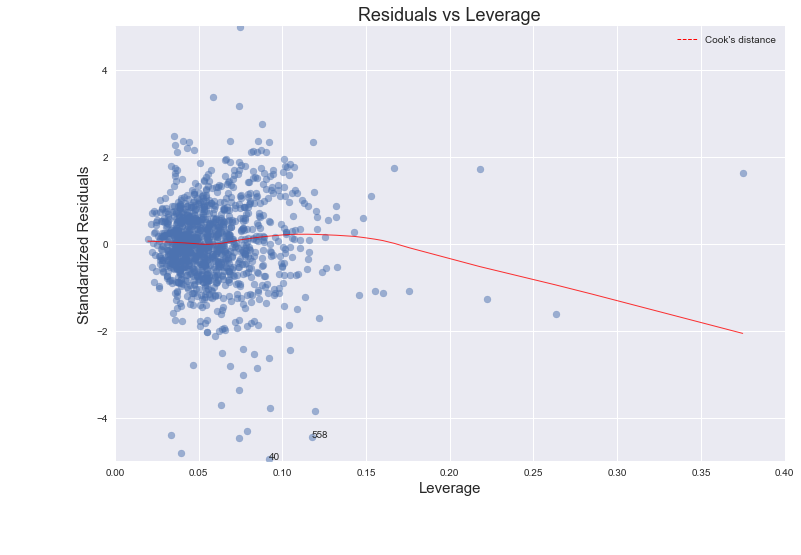

In [53]:

plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.4)
plot_lm_4.axes[0].set_ylim(-5, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');